In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm
from massimal import hyspec_cnn, image_render, annotation
import json
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Paths
train_pca_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v2/train/')
val_pca_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v2/val/')

train_pca_tile_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v2/train_tiles')
train_pca_tile_dir.mkdir(parents=True,exist_ok=True)

val_pca_tile_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v2/val_tiles')
val_pca_tile_dir.mkdir(parents=True,exist_ok=True)


In [3]:
# Parameters
wl_min = 400
wl_max = 730
minimum_reflectance = 0.001

grouped_class_indices = {
    'Sand': {9}, 
    'Bedrock': {4}, 
    'Maerl': {33}, 
    'Rockweed': {19, 20, 21, 22, 23, 25, 26, 27}, 
    'Kelp': {13, 14, 15}, 
    'Chorda filum': {29}, 
    'Brown algae (deep)': {12, 16, 17, 18, 24, 30}}

custom_cmap = matplotlib.colors.ListedColormap(colors=['darkgray',           # Background - darkgray 
                                                       'darkturquoise',   # Sand
                                                       'pink',            # Bedrock
                                                       'magenta',         # Maerl bed
                                                       'seagreen',        # Rockweed
                                                       'darkorange',      # Kelp 
                                                       'red',             # Chorda filum (alt. 'lime'?)
                                                       'brown'])          # Brown algae

In [4]:
# Disable GPUs (avoid out of memory error while constructing dataset)
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'
print(f'{visible_devices=}')
print(f'{tf.version.VERSION=}')

visible_devices=[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
tf.version.VERSION='2.8.0'


In [5]:
def extract_pca_tiles(dataset_dir_path, grouped_class_indices):
    TILE_SHAPE = (128,128)
    dataset_paths = sorted([path for path in dataset_dir_path.glob('*')])
    
    tiles_dataset_list = []
    
    for dataset_path in tqdm.tqdm(dataset_paths):
        dataset = tf.data.experimental.load(str(dataset_path))

        # Load data
        pca_im, label_im = [numpy_data for numpy_data in dataset.as_numpy_iterator()][0]
        
        # Split into tiles
        pca_tiles, label_tiles = hyspec_cnn.labeled_image_to_tensor_tiles(pca_im,label_im,TILE_SHAPE)

        # Create dataset from tiles
        if len(pca_tiles) > 0: # Some times no tiles are returned, skip these cases
            tile_image_names = tf.convert_to_tensor([dataset_path.name.split('-')[0] for _ in range(len(pca_tiles))])
            tiles_dataset_list.append(tf.data.Dataset.from_tensor_slices((pca_tiles,label_tiles,tile_image_names)))

    # Concatenate tiles
    tiles_concat = tiles_dataset_list[0]
    for i,tiles in enumerate(tiles_dataset_list[1:]):
        try:
            tiles_concat = tiles_concat.concatenate(tiles)
        except Exception as e:
            print(f'Error at tile batch {i}:')
            print(tiles)
            print(e)
    return tiles_concat

In [6]:
# Extract tiles
train_tiles_dataset = extract_pca_tiles(train_pca_im_dir,grouped_class_indices)
print(f'Number of training tiles: {int(train_tiles_dataset.cardinality())}')
tf.data.experimental.save(train_tiles_dataset,path=str(train_pca_tile_dir / 'vega_sola_log_rrs_pca5_tiles'))

100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


Number of training tiles: 4437


In [7]:
# Extract tiles
val_tiles_dataset = extract_pca_tiles(val_pca_im_dir,grouped_class_indices)
print(f'Number of test tiles: {int(val_tiles_dataset.cardinality())}')
tf.data.experimental.save(val_tiles_dataset,path=str(val_pca_tile_dir / 'vega_sola_log_rrs_pca5_tiles'))

100%|██████████| 39/39 [00:09<00:00,  4.13it/s]


Number of test tiles: 2183


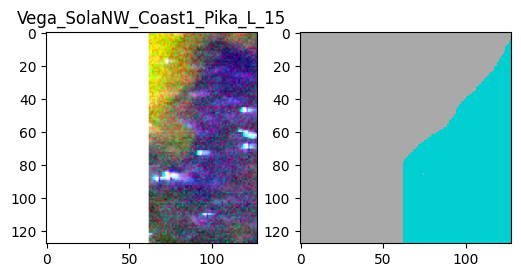

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]


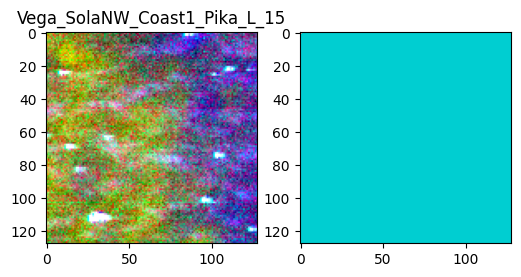

[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


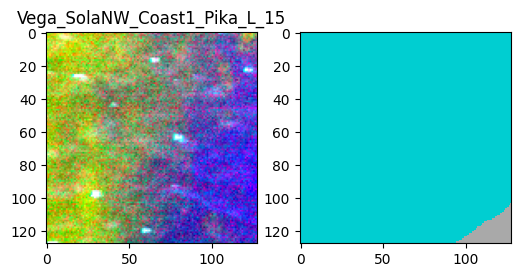

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1]


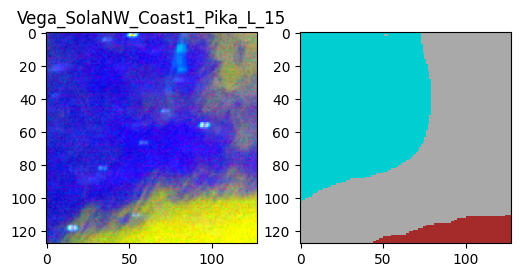

[0 1 7]


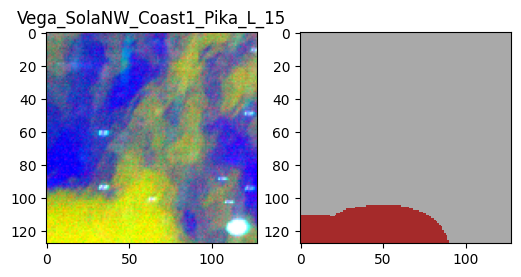

[0 7]


In [8]:
# Plot example training tiles and labels.
for pca_tile, label_tile, im_name in train_tiles_dataset.skip(200).take(5).as_numpy_iterator():
    fig,ax = plt.subplots(ncols=2,figsize=(6,4))
    ax[0].imshow(image_render.percentile_stretch(pca_tile[:,:,(2,1,0)]))
    ax[1].imshow(label_tile,cmap=custom_cmap, vmin=0,vmax=(len(grouped_class_indices)-0.01),interpolation='none')
    ax[0].set_title(tf.compat.as_str(im_name))
    plt.show()
    print(np.unique(label_tile))

In [10]:
# Check that tile labels are within correct range
tile_labels_unique = set()
for _, label_tile, _ in train_tiles_dataset.as_numpy_iterator():
    for label in np.unique(label_tile):
        tile_labels_unique.add(label)
print(f'All unique training tile labels: {tile_labels_unique}')
assert tile_labels_unique == {0, 1, 2, 3, 4, 5, 6, 7}

All unique training tile labels: {0, 1, 2, 3, 4, 5, 6, 7}


In [12]:
# Check that tile labels are within correct range
tile_labels_unique = set()
for _, label_tile, _ in val_tiles_dataset.as_numpy_iterator():
    for label in np.unique(label_tile):
        tile_labels_unique.add(label)
print(f'All unique test tile labels: {tile_labels_unique}')
assert tile_labels_unique == {0, 1, 2, 3, 4, 5, 6, 7}

All unique test tile labels: {0, 1, 2, 3, 4, 5, 6, 7}
